In [9]:
# !pip install -q flatbuffers 2> /dev/null
# !pip install -q mediapipe 2> /dev/null
# !pip install tensorflow==2.11.0
!pip install tensorflow-addons

In [10]:
## Animation Libraries Used
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

## Data analysis libraries used



## Model training libraies

import numpy as np

import tensorflow as tf
import tensorflow_addons as tfa

import matplotlib as mpl
import seaborn as sn

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GroupShuffleSplit 

import os
import json
import glob
import sys

import math
import gc
import sys
import sklearn
import scipy


import cv2
import matplotlib.pyplot as plt
from matplotlib import animation
from pathlib import Path
import IPython
from IPython.display import display
from IPython.display import HTML

import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2


print(f'Tensorflow V{tf.__version__}')
print(f'Keras V{tf.keras.__version__}')
print(f'Python V{sys.version}')

print(f' V{sys.version}')

Tensorflow V2.11.0
Keras V2.11.0
Python V3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]
 V3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]


In [11]:
DATA_DIR = "/kaggle/input/asl-signs"
# LANDMARK_FILES_DIR = os.path.join(DATA_DIR, "train_landmark_files")
TRAIN_FILE = os.path.join(DATA_DIR, "train.csv")
LABEL_MAP = json.load(open(os.path.join(DATA_DIR, "sign_to_prediction_index_map.json"), "r"))

print(TRAIN_FILE)
# print(LABEL_MAP)

/kaggle/input/asl-signs/train.csv


In [13]:
# how many training example (videos of signs)
train_df = pd.read_csv(TRAIN_FILE)
print(train_df.info())
display(train_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94477 entries, 0 to 94476
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            94477 non-null  object
 1   participant_id  94477 non-null  int64 
 2   sequence_id     94477 non-null  int64 
 3   sign            94477 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.9+ MB
None


,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


In [14]:
# Sign (label) statistics  - how many labels in the training set
print(train_df["sign"].describe().to_frame().T)
sign_count_map = train_df["sign"].value_counts().to_dict()
print("\t1. Number Of Unique Signs                  -->", len(sign_count_map))
print("\t2. Average Number of Rows Per Sign         -->", np.array(list(sign_count_map.values())).mean())
print("\t3. Standard Deviation in Counts Per Sign   -->", np.array(list(sign_count_map.values())).std())
print("\t4. Minimum Number of Examples For One Sign -->", np.array(list(sign_count_map.values())).min())
print("\t5. Maximum Number of Examples For One Sign -->", np.array(list(sign_count_map.values())).max())

# print("\n\n... SIGN COLUMN HISTOGRAM:\n")
# fig = px.histogram(train_df, y=train_df["sign"], color="sign", orientation="h", height=5000,
#     labels={"y":"<b>Sign (label)</b>", "count":"<b>Total Row Count</b>"}, title="<b>Row Counts by Sign (label)</b>",
#     category_orders={"sign": train_df["sign"].value_counts().index}
# )
# fig.update_yaxes(title_text="<b>Total Row Count</b>")
# fig.update_layout(showlegend=False)
# fig.show()

      count unique     top freq
sign  94477    250  listen  415
	1. Number Of Unique Signs                  --> 250
	2. Average Number of Rows Per Sign         --> 377.908
	3. Standard Deviation in Counts Per Sign   --> 19.356537293638034
	4. Minimum Number of Examples For One Sign --> 299
	5. Maximum Number of Examples For One Sign --> 415


In [15]:
# training example from how many participants

print("\n... BASICS OF THE PARTICIPANT ID COLUMN:\n")
print(train_df["participant_id"].astype(str).describe().to_frame().T)

participant_count_map = train_df["participant_id"].value_counts().to_dict()
print("\t1. Number of Unique Participants                  -->", len(participant_count_map))
print("\t2. Average Number of Rows Per Participant         -->", np.array(list(participant_count_map.values())).mean())
print("\t3. Standard Deviation in Counts Per Participant   -->", np.array(list(participant_count_map.values())).std())
print("\t4. Minimum Number of Examples For One Participant -->", np.array(list(participant_count_map.values())).min())
print("\t5. Maximum Number of Examples For One Participant -->", np.array(list(participant_count_map.values())).max())

# print("\n\n... PARTICIPANT ID COLUMN HISTOGRAM:\n")
# fig = px.histogram(
#     train_df, x=train_df["participant_id"].astype(str), color="participant_id",
#     labels={"x":"<b>Participant ID</b>", "count":"<b>Total Row Count</b>"}, title="<b>Row Counts by Participant ID</b>",
#     category_orders={"participant_id": train_df["participant_id"].value_counts().index}
# )
# fig.update_yaxes(title_text="<b>Total Row Count</b>")
# fig.update_layout(showlegend=False)
# fig.show()

# print("\n... GOING FORWARD WE SET THIS COLUMN TO BE A STRING")
# train_df["participant_id"] = train_df["participant_id"].astype(str)
# subsample_train_df["participant_id"] = subsample_train_df["participant_id"].astype(str)


... BASICS OF THE PARTICIPANT ID COLUMN:

                count unique    top  freq
participant_id  94477     21  49445  4968
	1. Number of Unique Participants                  --> 21
	2. Average Number of Rows Per Participant         --> 4498.9047619047615
	3. Standard Deviation in Counts Per Participant   --> 490.7731417304649
	4. Minimum Number of Examples For One Participant --> 3338
	5. Maximum Number of Examples For One Participant --> 4968


In [16]:
# first sign video frame file as sample to see the frame data 
# it has face, left
sample_sign_file_name = train_df.iloc[0]['path']
sample_sign_df = pd.read_parquet(os.path.join(DATA_DIR, sample_sign_file_name))
print("sign frames for sign ", train_df.iloc[0]['sign'] )
print(sample_sign_df)

sign frames for sign  blow
       frame            row_id        type  landmark_index         x  \
0         20         20-face-0        face               0  0.494400   
1         20         20-face-1        face               1  0.496017   
2         20         20-face-2        face               2  0.500818   
3         20         20-face-3        face               3  0.489788   
4         20         20-face-4        face               4  0.495304   
...      ...               ...         ...             ...       ...   
12484     42  42-right_hand-16  right_hand              16  0.001660   
12485     42  42-right_hand-17  right_hand              17  0.042694   
12486     42  42-right_hand-18  right_hand              18  0.006723   
12487     42  42-right_hand-19  right_hand              19 -0.014755   
12488     42  42-right_hand-20  right_hand              20 -0.031811   

              y         z  
0      0.380470 -0.030626  
1      0.350735 -0.057565  
2      0.359343 -0.03028

In [17]:
print(sample_sign_df['frame'].nunique()) # number of frames in this video of "blow" sign
sample_sign_df[sample_sign_df['frame'] == 20]['type'].value_counts()

23


type
face          468
pose           33
left_hand      21
right_hand     21
Name: count, dtype: int64

In [ ]:
# choose features - landmarks to use for classification
# Google mediapipe landmarks index: 468 face landmarks, 21 landmarks for each hand, and 
# https://developers.google.com/mediapipe/solutions/vision/pose_landmarker#:~:text=The%20MediaPipe%20Pose%20Landmarker%20task,with%20single%20images%20or%20video.
# The pose consists of a total of 33 landmark points with indices from 0 to 32. 
# pose : 0-10 are assigned to the face, 11-22 to the upper body, and 23-32 to the lower body.

# https://medium.com/@hotakoma/mediapipe-landmark-face-hand-pose-sequence-number-list-view-778364d6c414
# here in the sign video, each frame has 543 landmards:     
#    face: 0:468
#     left_hand: 468:489
#     pose: 489:522
#     right_hand: 522:544

# More resource: https://www.youtube.com/watch?v=hV5S4iQhNkI

# sample_sign_df[sample_sign_df['type'] == "face"].landmark_index
sample_sign_df[(sample_sign_df['frame'] == 20) & (sample_sign_df['type'] == 'pose')].landmark_index
# sample_sign_df[(sample_sign_df['frame'] == 20) & (sample_sign_df['type'] == 'left_hand')].landmark_index
# sample_sign_df[(sample_sign_df['frame'] == 20) & (sample_sign_df['type'] == 'right_hand')].landmark_index

In [18]:
thank_you_sign_file = train_df[train_df["sign"] == "thankyou"].iloc[1].path
path_to_sign = thank_you_sign_file
sign = pd.read_parquet(os.path.join(DATA_DIR, path_to_sign))
sign.y = sign.y * -1

In [20]:
def get_hand_points(hand):
    x = [[hand.iloc[0].x, hand.iloc[1].x, hand.iloc[2].x, hand.iloc[3].x, hand.iloc[4].x], # Thumb
         [hand.iloc[5].x, hand.iloc[6].x, hand.iloc[7].x, hand.iloc[8].x], # Index
         [hand.iloc[9].x, hand.iloc[10].x, hand.iloc[11].x, hand.iloc[12].x], 
         [hand.iloc[13].x, hand.iloc[14].x, hand.iloc[15].x, hand.iloc[16].x], 
         [hand.iloc[17].x, hand.iloc[18].x, hand.iloc[19].x, hand.iloc[20].x], 
         [hand.iloc[0].x, hand.iloc[5].x, hand.iloc[9].x, hand.iloc[13].x, hand.iloc[17].x, hand.iloc[0].x]]

    y = [[hand.iloc[0].y, hand.iloc[1].y, hand.iloc[2].y, hand.iloc[3].y, hand.iloc[4].y],  #Thumb
         [hand.iloc[5].y, hand.iloc[6].y, hand.iloc[7].y, hand.iloc[8].y], # Index
         [hand.iloc[9].y, hand.iloc[10].y, hand.iloc[11].y, hand.iloc[12].y], 
         [hand.iloc[13].y, hand.iloc[14].y, hand.iloc[15].y, hand.iloc[16].y], 
         [hand.iloc[17].y, hand.iloc[18].y, hand.iloc[19].y, hand.iloc[20].y], 
         [hand.iloc[0].y, hand.iloc[5].y, hand.iloc[9].y, hand.iloc[13].y, hand.iloc[17].y, hand.iloc[0].y]] 
    return x, y

def get_pose_points(pose):
    x = [[pose.iloc[8].x, pose.iloc[6].x, pose.iloc[5].x, pose.iloc[4].x, pose.iloc[0].x, pose.iloc[1].x, pose.iloc[2].x, pose.iloc[3].x, pose.iloc[7].x], 
         [pose.iloc[10].x, pose.iloc[9].x], 
         [pose.iloc[22].x, pose.iloc[16].x, pose.iloc[20].x, pose.iloc[18].x, pose.iloc[16].x, pose.iloc[14].x, pose.iloc[12].x, 
          pose.iloc[11].x, pose.iloc[13].x, pose.iloc[15].x, pose.iloc[17].x, pose.iloc[19].x, pose.iloc[15].x, pose.iloc[21].x], 
         [pose.iloc[12].x, pose.iloc[24].x, pose.iloc[26].x, pose.iloc[28].x, pose.iloc[30].x, pose.iloc[32].x, pose.iloc[28].x], 
         [pose.iloc[11].x, pose.iloc[23].x, pose.iloc[25].x, pose.iloc[27].x, pose.iloc[29].x, pose.iloc[31].x, pose.iloc[27].x], 
         [pose.iloc[24].x, pose.iloc[23].x]
        ]

    y = [[pose.iloc[8].y, pose.iloc[6].y, pose.iloc[5].y, pose.iloc[4].y, pose.iloc[0].y, pose.iloc[1].y, pose.iloc[2].y, pose.iloc[3].y, pose.iloc[7].y], 
         [pose.iloc[10].y, pose.iloc[9].y], 
         [pose.iloc[22].y, pose.iloc[16].y, pose.iloc[20].y, pose.iloc[18].y, pose.iloc[16].y, pose.iloc[14].y, pose.iloc[12].y, 
          pose.iloc[11].y, pose.iloc[13].y, pose.iloc[15].y, pose.iloc[17].y, pose.iloc[19].y, pose.iloc[15].y, pose.iloc[21].y], 
         [pose.iloc[12].y, pose.iloc[24].y, pose.iloc[26].y, pose.iloc[28].y, pose.iloc[30].y, pose.iloc[32].y, pose.iloc[28].y], 
         [pose.iloc[11].y, pose.iloc[23].y, pose.iloc[25].y, pose.iloc[27].y, pose.iloc[29].y, pose.iloc[31].y, pose.iloc[27].y], 
         [pose.iloc[24].y, pose.iloc[23].y]
        ]
    return x, y

The sign being shown here is: thankyou


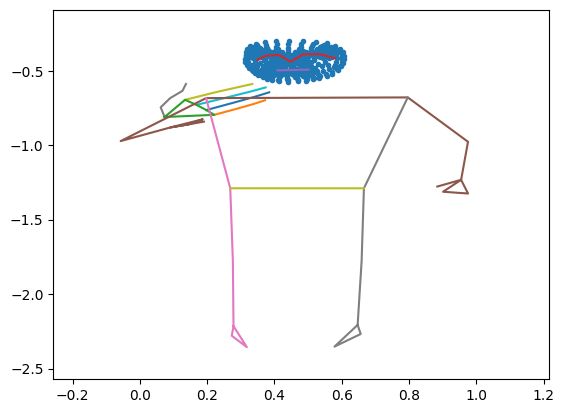

In [21]:
def animation_frame(f):
    frame = sign[sign.frame==f]
    left = frame[frame.type=='left_hand']
    right = frame[frame.type=='right_hand']
    pose = frame[frame.type=='pose']
    face = frame[frame.type=='face'][['x', 'y']].values
    lx, ly = get_hand_points(left)
    rx, ry = get_hand_points(right)
    px, py = get_pose_points(pose)
    ax.clear()
    ax.plot(face[:,0], face[:,1], '.')
    for i in range(len(lx)):
        ax.plot(lx[i], ly[i])
    for i in range(len(rx)):
        ax.plot(rx[i], ry[i])
    for i in range(len(px)):
        ax.plot(px[i], py[i])
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
        
print(f"The sign being shown here is: {train_df[train_df.path==f'{path_to_sign}'].sign.values[0]}")

## These values set the limits on the graph to stabilize the video
xmin = sign.x.min() - 0.2
xmax = sign.x.max() + 0.2
ymin = sign.y.min() - 0.2
ymax = sign.y.max() + 0.2

fig, ax = plt.subplots()
l, = ax.plot([], [])
fun_animation = FuncAnimation(fig, func=animation_frame, frames=sign.frame.unique())

HTML(fun_animation.to_html5_video())

In [23]:
# 3D visualization 
# https://www.kaggle.com/code/ted0071/gislr-visualization

In [25]:
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = False

In [26]:
class Cfg:
    RANDOM_STATE = 2023
    INPUT_ROOT = Path('/kaggle/input/asl-signs/')
    OUTPUT_ROOT = Path('kaggle/working')
    INDEX_MAP_FILE = INPUT_ROOT / 'sign_to_prediction_index_map.json'
    TRAN_FILE = INPUT_ROOT / 'train.csv'
    INDEX = 'sequence_id'
    ROW_ID = 'row_id'

In [27]:
print(f'cv2 version: {cv2.__version__}')
print(f'MediaPipe version: {mp.__version__}')
print(f'IPython version: {IPython.__version__}')

cv2 version: 4.9.0
MediaPipe version: 0.10.10
IPython version: 8.20.0


In [29]:
def read_index_map(file_path=Cfg.INDEX_MAP_FILE):
    """Reads the sign to predict as json file."""
    with open(file_path, "r") as f:
        result = json.load(f)
    return result    

def read_train(file_path=Cfg.TRAN_FILE):
    """Reads the train csv as pandas data frame."""
    return pd.read_csv(file_path).set_index(Cfg.INDEX)

def read_landmark_data_by_path(file_path, input_root=Cfg.INPUT_ROOT):
    """Reads landmak data by the given file path."""
    data = pd.read_parquet(input_root / file_path)
    return data.set_index(Cfg.ROW_ID)

def read_landmark_data_by_id(sequence_id, train_data):
    """Reads the landmark data by the given sequence id."""
    file_path = train_data.loc[sequence_id]['path']
    return read_landmark_data_by_path(file_path)



mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands
mp_face_mesh = mp.solutions.face_mesh
mp_pose = mp.solutions.pose

def get_random_sequence_id(train_data):
    idx = np.random.randint(0, len(train_data))
    return train_data.index[idx]

# def create_blank_image(height, width):
#     return np.zeros((height, width, 3), np.uint8)

def create_blank_image(height, width):
    return np.ones((height, width, 3), np.uint8)

def draw_landmarks(
    data, 
    image, 
    frame_id, 
    landmark_type, 
    connection_type, 
    landmark_color=(255, 0, 0), 
    connection_color=(0, 20, 255), 
    thickness=1, 
    circle_radius=1
):
    """Draws landmarks"""
    df = data.groupby(['frame', 'type']).get_group((frame_id, landmark_type))
    landmarks = [landmark_pb2.NormalizedLandmark(x=lm.x, y=lm.y, z=lm.z) for idx, lm in df.iterrows()]
    landmark_list = landmark_pb2.NormalizedLandmarkList(landmark = landmarks)

    mp_drawing.draw_landmarks(
        image=image,
        landmark_list=landmark_list, 
        connections=connection_type,
        landmark_drawing_spec=mp_drawing.DrawingSpec(
            color=landmark_color, 
            thickness=thickness, 
            circle_radius=circle_radius),
        connection_drawing_spec=mp_drawing.DrawingSpec(
            color=connection_color, 
            thickness=thickness, 
            circle_radius=circle_radius))
    return image

def draw_left_hand(data, image, frame_id):
    return draw_landmarks(
        data, 
        image, 
        frame_id, 
        landmark_type='left_hand', 
        connection_type=mp_hands.HAND_CONNECTIONS,
        landmark_color=(255, 0, 0),
#         connection_color=(0, 20, 255),
        connection_color=(0, 255, 0),
        thickness=3, 
        circle_radius=3)

def draw_right_hand(data, image, frame_id):
    return draw_landmarks(
        data, 
        image, 
        frame_id, 
        landmark_type='right_hand', 
        connection_type=mp_hands.HAND_CONNECTIONS,
        landmark_color=(255, 0, 0),
#         connection_color=(0, 20, 255),
        connection_color=(0, 255, 0),
        thickness=3, 
        circle_radius=3)

def draw_face(data, image, frame_id):
    return draw_landmarks(
        data, 
        image, 
        frame_id, 
        landmark_type='face', 
        connection_type=mp_face_mesh.FACEMESH_TESSELATION,
        landmark_color=(255, 255, 255),
        connection_color=(0, 255, 0))      
    
def draw_pose(data, image, frame_id):
    return draw_landmarks(
        data, 
        image, 
        frame_id, 
        landmark_type='pose', 
        connection_type=mp_pose.POSE_CONNECTIONS,
#         landmark_color=(255, 255, 255),
#         connection_color=(255, 0, 0),
        landmark_color=(255, 0, 0),
        connection_color=(0, 255, 0),
        thickness=2, 
        circle_radius=2)

def create_frame(data, frame_id, height=1000, width=1000):
    image = create_blank_image(height, width)    

    draw_pose(data, image, frame_id) 
    draw_left_hand(data, image, frame_id)    
    draw_right_hand(data, image, frame_id)  
    draw_face(data, image, frame_id)
     
    return image

/tmp/ipykernel_34/2463502842.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  frame_id = data['frame'][0]


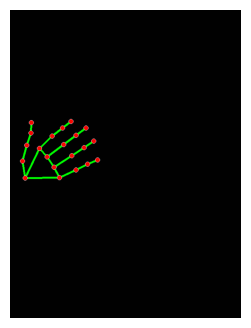

In [30]:
train_data = read_train()


height = 800
width = 600

sequence_id = 1000106739
data = read_landmark_data_by_id(sequence_id, train_data)

frame_id = data['frame'][0]

_, ax = plt.subplots(1, 1, figsize=(4, 4))
image = draw_right_hand(data, image=create_blank_image(height, width), frame_id=frame_id)
 
ax.imshow(image)
ax.axis('off')

plt.show()

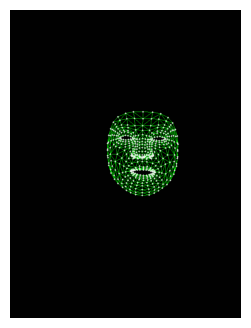

In [31]:
_, ax = plt.subplots(1, 1, figsize=(4, 4))
image = draw_face(data, image=create_blank_image(height, width), frame_id=frame_id)
 
ax.imshow(image)
ax.axis('off')

plt.show()

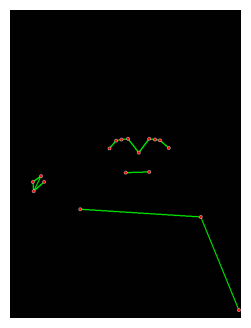

In [32]:
_, ax = plt.subplots(1, 1, figsize=(4, 4))
image = draw_pose(data, image=create_blank_image(height, width), frame_id=frame_id)
 
ax.imshow(image)
ax.axis('off')

plt.show()

/tmp/ipykernel_34/1992613220.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  frame_id = data['frame'][0]


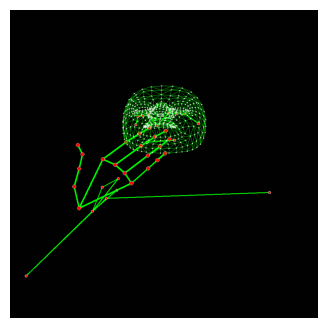

In [33]:
train_data = read_train()

def read_landmark_data_by_sign(sign_string, train_data):
    """Reads the landmark data by the given sequence id."""
    file_path = train_data[train_data['sign'] == sign_string].iloc[0]['path']
    return read_landmark_data_by_path(file_path)

height = 800
width = 600


data = read_landmark_data_by_sign("thankyou", train_data)
frame_id = data['frame'][0]

_, ax = plt.subplots(1, 1, figsize=(4, 4))

image = create_frame(data, frame_id=frame_id)
 
ax.imshow(image)
ax.axis('off')
plt.savefig('/kaggle/working/thankyou_plot.png', dpi=300)
plt.show()

In [34]:
def create_frames(sequence_id, train_data, height=800, width=800):
    data = read_landmark_data_by_id(sequence_id, train_data)
    frame_ids = data['frame'].unique()
    images = [create_frame(data, frame_id=fid, height=height, width=width) for fid in frame_ids]
    return np.array(images)


def create_animation(images, fig, ax):
    ax.axis('off')
    
    ims = []
    for img in images:
        im = ax.imshow(img, animated=True)
        ims.append([im])
    
    func_animation = mpl.animation.ArtistAnimation(
        fig, 
        ims, 
        interval=100, 
        blit=True,
        repeat_delay=1000)

    return func_animation

def get_sign_by_id(sequence_id, train_data):
    return train_data.loc[sequence_id]['sign']

def play_animation(sequence_id, train_data, height, width, figsize=(4, 4)):
    frames = create_frames(sequence_id, train_data, height=height, width=width)
    sign = get_sign_by_id(sequence_id, train_data)
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    anim = create_animation(frames, fig, ax)
    ax.set_title(f'Sign: {sign}')
    
    video = anim.to_html5_video()
    html = IPython.display.HTML(video)
    IPython.display.display(html)
    plt.close()

In [35]:
sequence_id = get_random_sequence_id(train_data)
play_animation(sequence_id, train_data, height=height, width=width)

In [36]:
data = train_data[train_data['sign'] == 'happy']
sequence_id = get_random_sequence_id(data)

play_animation(sequence_id, train_data, height=height, width=width)

In [37]:
data = train_data[train_data['sign'] == 'thankyou']
sequence_id = get_random_sequence_id(data)

play_animation(sequence_id, train_data, height=height, width=width)

# _, ax = plt.subplots(1, 1, figsize=(4, 4))
# image = create_frame(data, frame_id=frame_id)
 
# ax.imshow(image)
# ax.axis('off')

# plt.show()

In [39]:
def create_gif(sequence_id, train_data, height, width, figsize=(4, 4)):
    frames = create_frames(sequence_id, train_data, height=height, width=width)
    sign = get_sign_by_id(sequence_id, train_data)
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    anim = create_animation(frames, fig, ax)
    # Save the animation as a GIF
    anim.save('sign.gif', writer='imagemagick')
    plt.close()

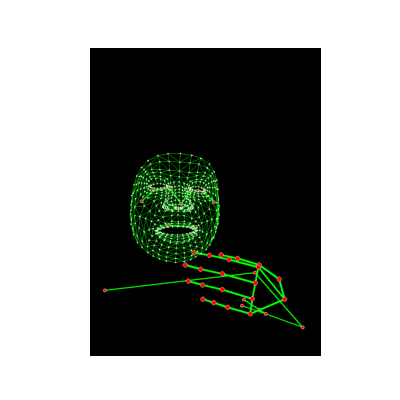

In [40]:
data = train_data[train_data['sign'] == 'thankyou']
sequence_id = get_random_sequence_id(data)

create_gif(sequence_id, train_data, height=height, width=width)
# Display the GIF
IPython.display.Image(filename='/kaggle/working/sign.gif')

In [42]:
def save_each_frame(sequence_id, train_data, height, width, figsize=(4, 4)):
    frames = create_frames(sequence_id, train_data, height=height, width=width)
    fig, ax = plt.subplots(figsize=figsize)
    for i, frame in enumerate(frames):
        ax.clear()  # Clear the previous frame
        ax.imshow(frame)
        ax.axis('off')  # Hide the axis
        plt.savefig(f'/kaggle/working/frame_{i:03d}.png')
    plt.close(fig)  # Close the figure after saving all frames

In [43]:
# !rm /kaggle/working/frame_*
# !rm /kaggle/working/frames.zip
# # !rm /kaggle/working/kaggle_working_files.zip

In [46]:
data = train_data[train_data['sign'] == 'thankyou']
sequence_id = get_random_sequence_id(data)
save_each_frame(sequence_id, train_data, height=height, width=width)

In [45]:
import os
import zipfile
import fnmatch

# Define the directory containing the frames
dir_to_zip = '/kaggle/working'

# Define the output ZIP file name
zip_file_path = '/kaggle/working/frames.zip'

# Create a ZIP file
with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Walk through the directory
    for root, dirs, files in os.walk(dir_to_zip):
        for file in fnmatch.filter(files, 'frame_*.png'):
            # Create a relative path for files to keep the directory structure
            relative_path = os.path.relpath(os.path.join(root, file), os.path.join(dir_to_zip, '..'))
            zipf.write(os.path.join(root, file), relative_path)

print(f"Only 'frame_*.png' files in '{dir_to_zip}' are zipped into '{zip_file_path}'")

Only 'frame_*.png' files in '/kaggle/working' are zipped into '/kaggle/working/frames.zip'
